In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d thienkhonghoc/affectnet

Dataset URL: https://www.kaggle.com/datasets/thienkhonghoc/affectnet
License(s): unknown
100% 1.74G/1.75G [01:50<00:00, 18.7MB/s]
100% 1.75G/1.75G [01:50<00:00, 16.9MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/affectnet.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [ ]:

train_dir = "/content/AffectNet/train"
val_dir = "/content/AffectNet/val"
# test_dir ="test"

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 30
FINE_TUNING_EPOCHS = 20
LR = 0.01
NUM_CLASSES = 7
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
CLASS_LABELS_EMOJIS = ["👿", "🤢" , "😱" , "😊" , "😐 ", "😔" , "😲" ]


In [ ]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True ,
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = val_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 30043 images belonging to 8 classes.
Found 7510 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


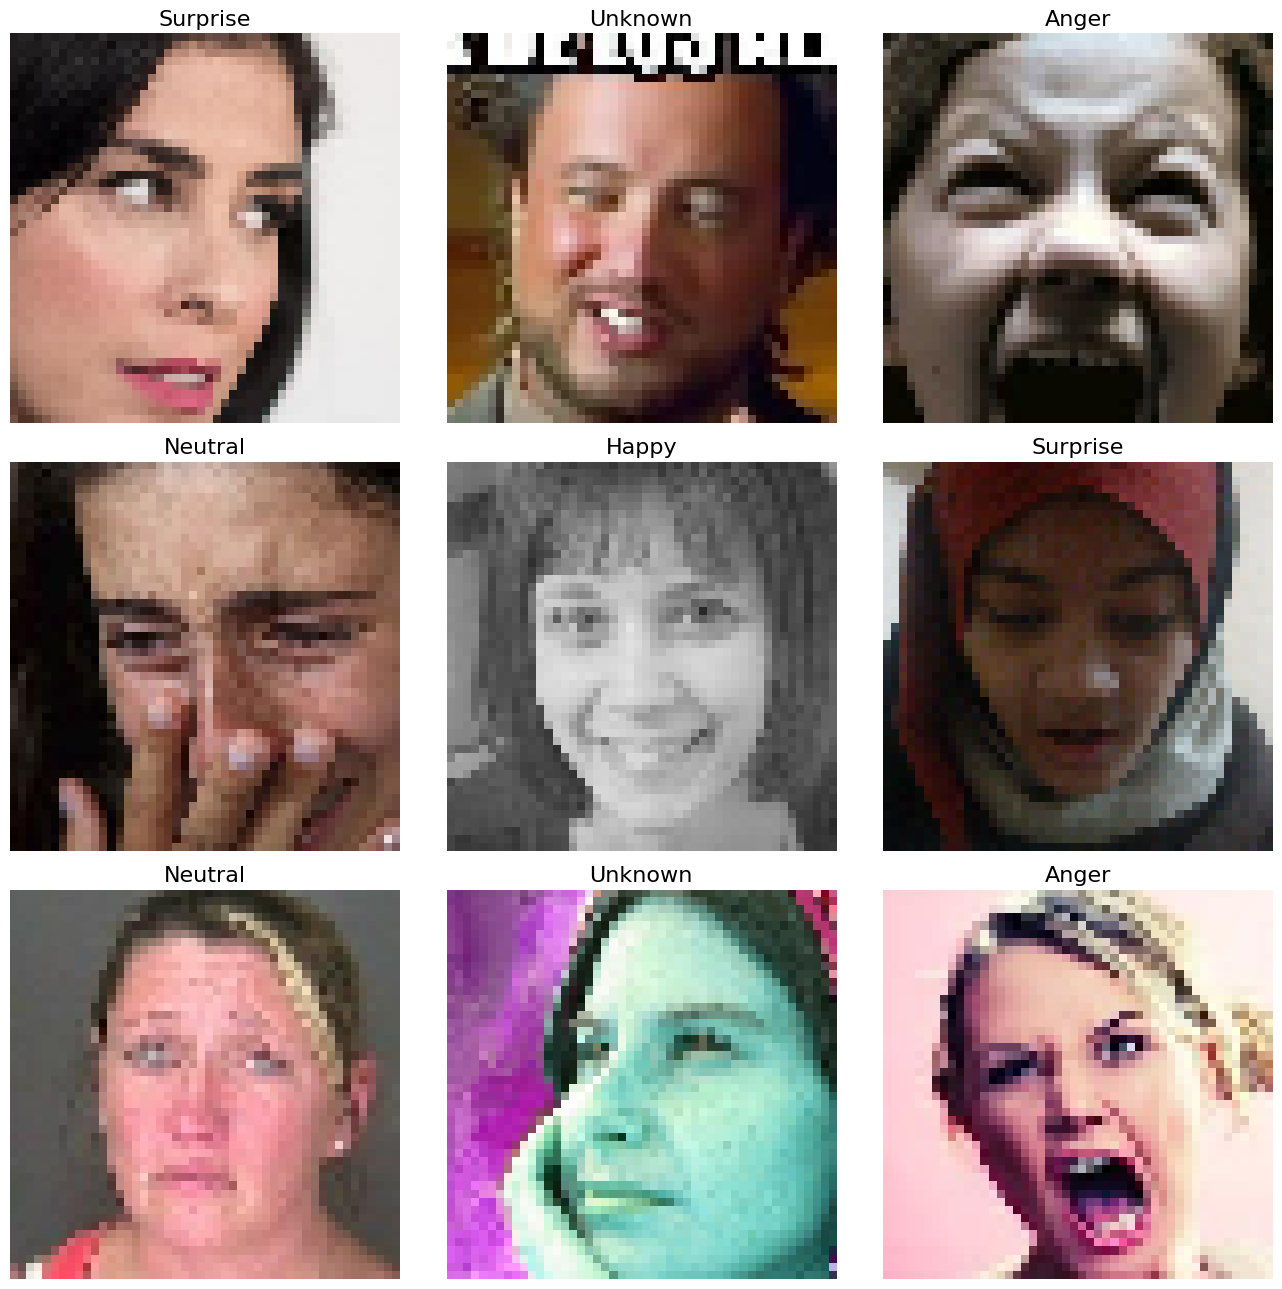

In [ ]:
# # Helper Functions
# def display_one_image(image, title, subplot, color):
#     plt.subplot(subplot)
#     plt.axis('off')
#     plt.imshow(image)
#     plt.title(title, fontsize=16)

# def display_nine_images(images, titles, title_colors=None):
#     subplot = 331
#     plt.figure(figsize=(13,13))
#     for i in range(9):
#         color = 'black' if title_colors is None else title_colors[i]
#         display_one_image(images[i], titles[i], 331+i, color)
#     plt.tight_layout()
#     plt.subplots_adjust(wspace=0.1, hspace=0.1)
#     plt.show()

# def image_title(label, prediction):
#   # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
#     class_idx = np.argmax(label, axis=-1)
#     prediction_idx = np.argmax(prediction, axis=-1)
#     if class_idx == prediction_idx:
#         return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
#     else:
#         return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

# def get_titles(images, labels, model):
#     predictions = model.predict(images)
#     titles, colors = [], []
#     for label, prediction in zip(classes, predictions):
#         title, color = image_title(label, prediction)
#         titles.append(title)
#         colors.append(color)
#     return titles, colors

# img_datagen = ImageDataGenerator(rescale = 1./255)
# img_generator = img_datagen.flow_from_directory(directory = train_dir,
#                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
#                                                     batch_size = BATCH_SIZE,
#                                                     shuffle  = True ,
#                                                     color_mode = "rgb",
#                                                     class_mode = "categorical",
#                                                     seed = 12
#                                                   )
# clear_output()

# images, classes = next(img_generator)
# class_idxs = np.argmax(classes, axis=-1)
# labels = [CLASS_LABELS[idx] for idx in class_idxs]
# display_nine_images(images, labels)

# Helper Functions
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)

def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True ,
                                                    color_mode = "rgb",
                                                    # The number of classes has been updated from 7 to 8
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )
clear_output()

images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=-1)
# Added a check to handle indices out of range in CLASS_LABELS
labels = [CLASS_LABELS[idx] if idx < len(CLASS_LABELS) else "Unknown" for idx in class_idxs]
display_nine_images(images, labels)

In [ ]:
# fig = px.bar(x = CLASS_LABELS_EMOJIS,
#              y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] ,
#              color = np.unique(train_generator.classes) ,
#              color_continuous_scale="Emrld")
# fig.update_xaxes(title="Emotions")
# fig.update_yaxes(title = "Number of Images")
# fig.update_layout(showlegend = True,
#     title = {
#         'text': 'Train Data Distribution ',
#         'y':0.95,
#         'x':0.5,
#         'xanchor': 'center',
#         'yanchor': 'top'})
# fig.show()

fig = px.bar(x = CLASS_LABELS_EMOJIS,
             # Removed the extra class from the count
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)[:-1]] ,
             color = np.unique(train_generator.classes)[:-1] ,
             color_continuous_scale="Emrld")
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [ ]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)

    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)

    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)

    return classification_output

def define_compile_model():

    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)

    model.compile(optimizer=tf.keras.optimizers.SGD(0.1),
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

    return model

In [ ]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet169 (Functional)             │ (None, 1, 1, 1664)          │      12,642,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1664)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         426,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification (Dense)               │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,860,679 (52.87 MB)

 Trainable params: 1,217,799 (4.65 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

In [ ]:
# earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                          patience=EARLY_STOPPING_CRITERIA,
#                                                          verbose= 1 ,
#                                                          restore_best_weights=True
#                                                         )

# history = model.fit(x = train_generator,
#                     epochs = EPOCHS ,
#                     validation_data = validation_generator ,
#                     callbacks= [earlyStoppingCallback])

# history = pd.DataFrame(history.history)

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    # Changed NUM_CLASSES to 8 to match the number of classes in the dataset
    x = tf.keras.layers.Dense(8, activation="softmax", name="classification")(x)

    return x

In [ ]:
# # Un-Freezing the feature extraction layers for fine tuning
# model.layers[1].trainable = True

# model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
#                 loss='categorical_crossentropy',
#                 metrics = ['accuracy'])

# history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)
# history = pd.DataFrame(history_.history) # Create history variable

# ipython-input-0-a568e1afe3d2
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()


# ipython-input-11-a568e1afe3d2
# Un-Freezing the feature extraction layers for fine tuning
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)
history = pd.DataFrame(history_.history) # Initialize history to an empty dataframe if you intend to concatenate later
history = pd.concat([history, pd.DataFrame(history_.history)], ignore_index=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet169 (Functional)             │ (None, 1, 1, 1664)          │      12,642,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1664)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         426,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification (Dense)               │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,861,192 (52.88 MB)

 Trainable params: 1,218,312 (4.65 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

Epoch 1/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 378s 525ms/step - accuracy: 0.1228 - loss: 17.5150 - val_accuracy: 0.1305 - val_loss: 17.5833
Epoch 2/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 147s 310ms/step - accuracy: 0.1344 - loss: 17.0934 - val_accuracy: 0.1559 - val_loss: 16.8377
Epoch 3/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 200s 305ms/step - accuracy: 0.1383 - loss: 16.7894 - val_accuracy: 0.1699 - val_loss: 16.5535
Epoch 4/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 166s 349ms/step - accuracy: 0.1432 - loss: 16.5055 - val_accuracy: 0.1790 - val_loss: 16.2798
Epoch 5/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 146s 307ms/step - accuracy: 0.1508 - loss: 16.2252 - val_accuracy: 0.1887 - val_loss: 16.0083
Epoch 6/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 206s 316ms/step - accuracy: 0.1566 - loss: 15.9570 - val_accuracy: 0.1879 - val_loss: 15.7433
Epoch 7/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 142s 298ms/step - accuracy: 0.1613 - loss: 15.6907 - val_accuracy: 0.1928 - val_loss: 15.4777
Epoch 8/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 147s 309ms/step - accu

In [ ]:
x = px.line(data_frame= history ,
            y= ["loss" , "val_loss"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [ ]:
# x = px.line(data_frame= history , y= ["accuracy" , "val_accuracy"] ,markers = True )
# x.update_xaxes(title="Number of Epochs")
# x.update_yaxes(title = "Accuracy")
# x.update_layout(showlegend = True,
#     title = {
#         'text': 'Accuracy vs Number of Epochs',
#         'y':0.94,
#         'x':0.5,
#         'xanchor': 'center',
#         'yanchor': 'top'})
# x.show()
!pip install plotly
import plotly.express as px # imports the plotly.express module and aliases it as px
history = pd.DataFrame()
x = px.line(data_frame= history , y= ["accuracy" , "val_accuracy"] ,markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [ ]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3049 - loss: 12.3937
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step


[0 2 3 4 5 6 7]
[0 1 2 3 4 5 6 7]


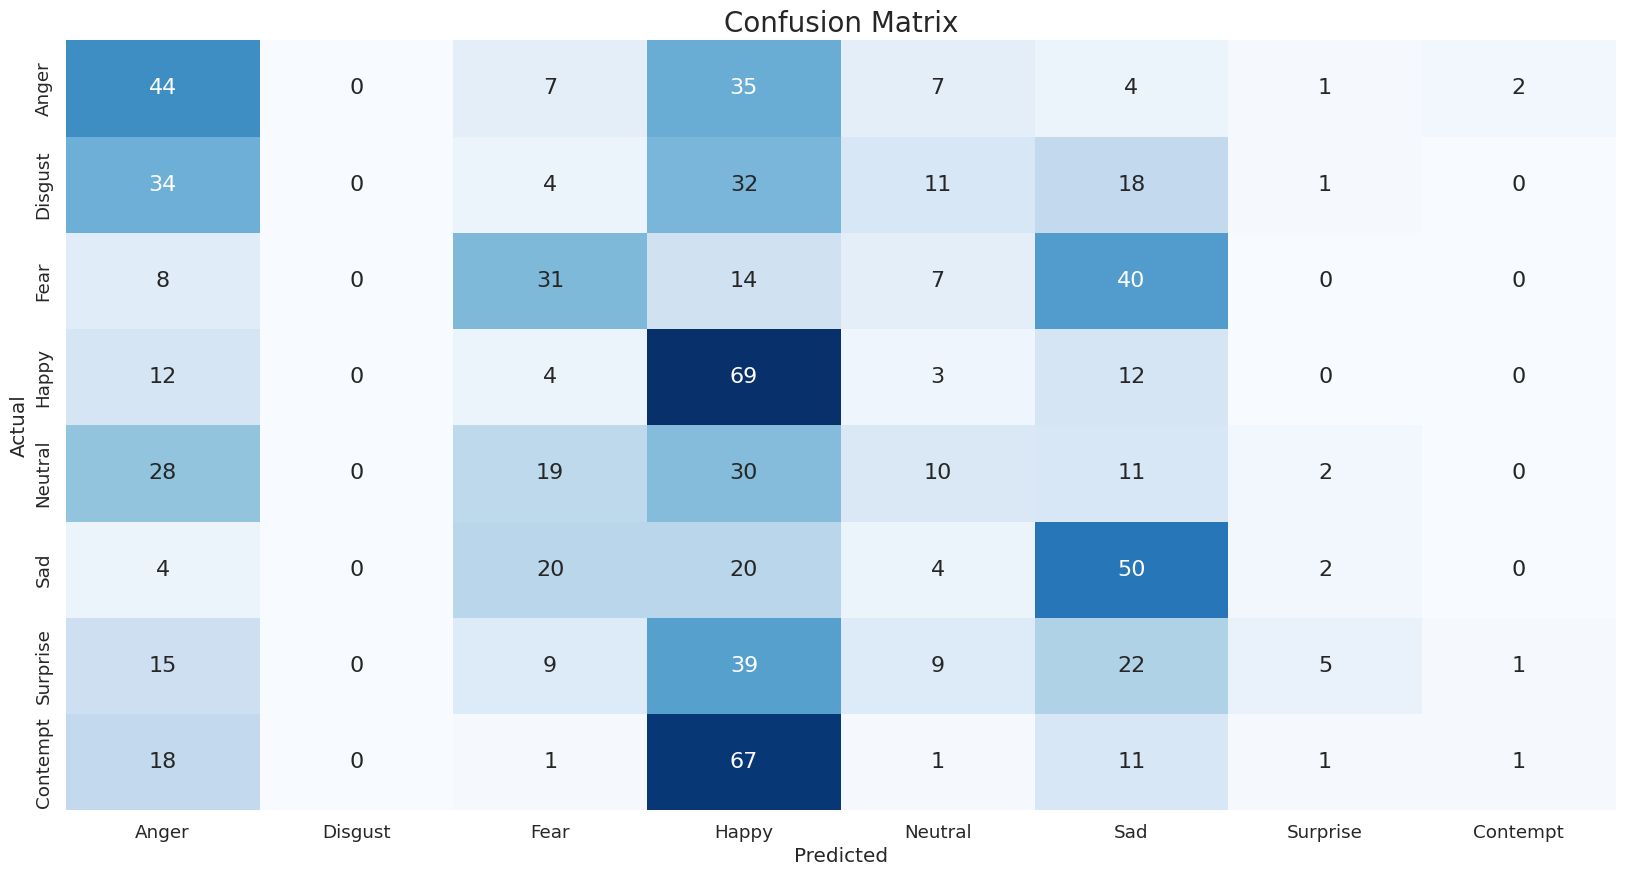

In [ ]:
# cm_data = confusion_matrix(y_test , y_preds)
# cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
# cm.index.name = 'Actual'
# cm.columns.name = 'Predicted'
# plt.figure(figsize = (20,10))
# plt.title('Confusion Matrix', fontsize = 20)
# sns.set(font_scale=1.2)
# ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')


!pip install seaborn matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# Check unique values in y_preds and y_test
print(np.unique(y_preds))
print(np.unique(y_test))

# Update CLASS_LABELS to include all classes found in y_preds and y_test
CLASS_LABELS = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise', 'Contempt'] # Add 'Contempt' to CLASS_LABELS

# Recalculate cm_data with the updated CLASS_LABELS
cm_data = confusion_matrix(y_test , y_preds)

cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')



In [ ]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.27      0.44      0.33       100
           1       0.00      0.00      0.00       100
           2       0.33      0.31      0.32       100
           3       0.23      0.69      0.34       100
           4       0.19      0.10      0.13       100
           5       0.30      0.50      0.37       100
           6       0.42      0.05      0.09       100
           7       0.25      0.01      0.02       100

    accuracy                           0.26       800
   macro avg       0.25      0.26      0.20       800
weighted avg       0.25      0.26      0.20       800



ROC AUC score: 0.7084484375


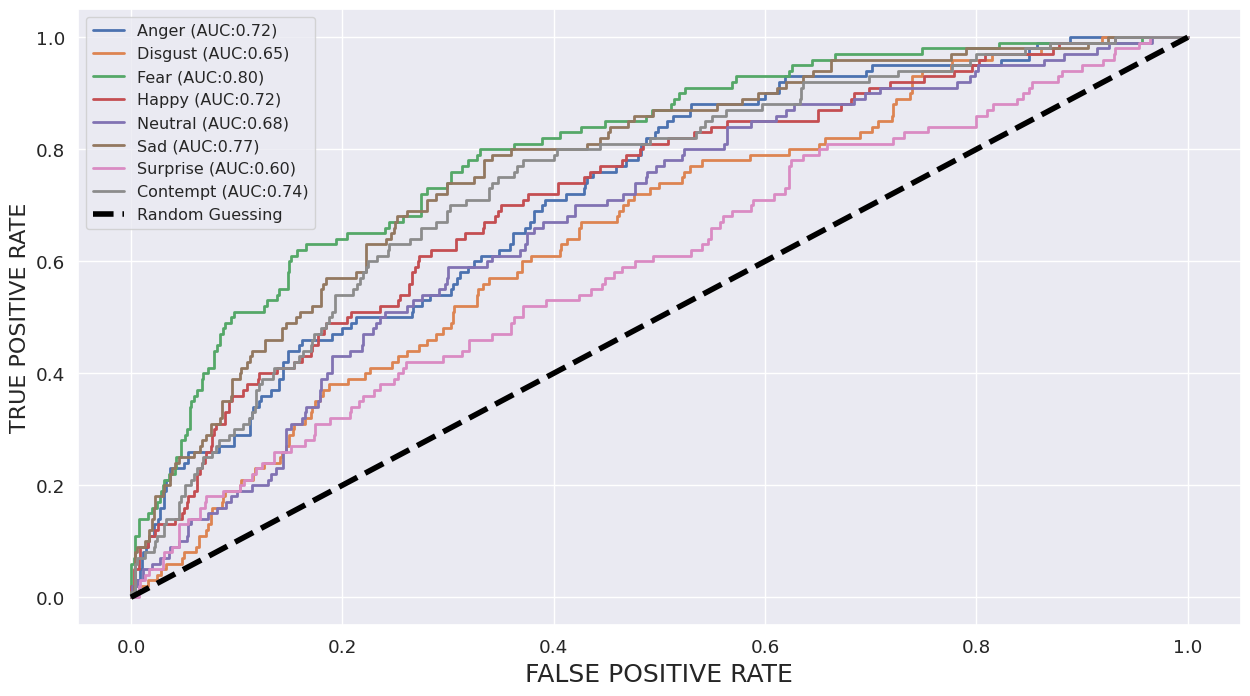

In [ ]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [ ]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

ROC-AUC Score  =  0.7101589285714285


In [ ]:
model.save("2nd model.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
